In [11]:
# Import necessary libraries
import ee  # Google Earth Engine API for geospatial data processing
import os  # File system operations
import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Visualization library

# Initialize the Earth Engine API
# Authenticates and prepares Earth Engine for use.
ee.Initialize()

### Input Data Path and Parameters

In [12]:
# Load datasets
# Global Forest Watch dataset for global forest changes (loss and gain data)
gfw = ee.Image('UMD/hansen/global_forest_change_2023_v1_11')

# MapBiomas datasets for deforestation and land cover
mapbiomas_deforestation = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection9/mapbiomas_collection90_deforestation_secondary_vegetation_v1')
mapbiomas_landcover = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection9/mapbiomas_collection90_integration_v1')

# Brazilian biomes data, representing geographic boundaries
biomes = ee.FeatureCollection('projects/mapbiomas-territories/assets/TERRITORIES/LULC/BRAZIL/COLLECTION9/WORKSPACE/BIOMES')

# Define analysis parameters
start_year = 2010  # Start year for analysis
end_year = 2023  # End year for analysis
resolution = 500  # Spatial resolution (in meters) for Earth Engine analysis
column_list = ['Biome', 'Deforestation Area (ha)', 'Year or Range', 'Dataset']  # Column names for resulting DataFrame
dataset = ['GFW', 'Mapbiomas']  # List of datasets being used

# Define land cover classes representing cropland
cropland_classes = [18, 19, 39, 20, 40, 62, 41, 36, 46, 47, 35, 48]  # Classification codes for cropland

# Initialize empty lists to store results for GFW and MapBiomas datasets
gfw_results = []
mapbiomas_result = []

# Convert dataset identifiers to lowercase for consistency
data_type1 = dataset[0].lower()  # 'gfw'
data_type2 = dataset[1].lower()  # 'mapbiomas'

#### Functions

In [13]:
# Function to calculate deforestation trends using GFW data
def calculate_gfw_timeline_deforestation(image, biome_collection, start_year, end_year, resolution, column_list):
    """
    Calculate deforestation trends using GFW dataset.
    Args:
        image (ee.Image): The GFW dataset.
        biome_collection (ee.FeatureCollection): Biomes' geographic boundaries.
        start_year (int): Start year for deforestation analysis.
        end_year (int): End year for deforestation analysis.
        resolution (int): Analysis resolution (in meters).
        column_list (list): Column names for output DataFrame.

    Returns:
        pd.DataFrame: Deforestation statistics for each biome.
    """
    def calculate_stats(feature):
        # Offset years by 2000 (GFW's year encoding starts at 2000)
        strt_yr = start_year - 2000
        end_yr = end_year - 2000
        
        # Mask forest loss for the specified range of years
        forest_loss_2010_2023 = image.select('lossyear').gte(strt_yr).And(image.select('lossyear').lte(end_yr))
        masked_loss = image.select('loss').updateMask(forest_loss_2010_2023)

        # Calculate deforestation area (in square meters)
        loss_area = masked_loss.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),  # Sum pixel areas within the region
            geometry=feature.geometry(),  # Restrict to the current biome
            scale=resolution,  # Spatial resolution
            bestEffort=True,  # Allow dynamic adjustment for large geometries
            maxPixels=1e10  # Maximum number of pixels to process
        ).get('loss')

        # Add the deforestation area (in hectares) as a property of the feature
        return feature.set('Deforestation_ha', ee.Number(loss_area).divide(10000))  # Convert m² to ha

    # Apply the calculation to each biome in the collection
    results = biome_collection.map(calculate_stats)

    # Extract results as a list and convert to a DataFrame
    deforestation_stats = results.reduceColumns(
        reducer=ee.Reducer.toList(2),
        selectors=['Bioma', 'Deforestation_ha']  # Properties to extract
    ).get('list').getInfo()

    return pd.DataFrame(deforestation_stats, columns=[column_list[0], column_list[1]])


# Function to calculate deforestation trends using MapBiomas data
def calculate_mb_timeline_deforestation(image, biome_collection, start_year, end_year, resolution, column_list):
    """
    Calculate deforestation trends using the MapBiomas dataset.
    Args:
        image (ee.Image): The MapBiomas deforestation dataset.
        biome_collection (ee.FeatureCollection): Biomes' geographic boundaries.
        start_year (int): Start year for deforestation analysis.
        end_year (int): End year for deforestation analysis.
        resolution (int): Analysis resolution (in meters).
        column_list (list): Column names for output DataFrame.

    Returns:
        pd.DataFrame: Deforestation statistics for each biome.
    """
    def calculate_stats(feature):
        # Initialize total deforestation for the biome
        total_deforestation = ee.Number(0)

        # Loop through each year in the range
        for year in range(start_year, end_year):
            year_band = f'classification_{year}'  # Current year's band
            next_year_band = f'classification_{year + 1}'  # Next year's band

            # Check if the next year's band exists
            if next_year_band in image.bandNames().getInfo():
                # Detect transitions from natural vegetation to anthropic land uses
                deforestation_mask = image.select(next_year_band).gte(400).And(
                    image.select(next_year_band).lt(500)
                ).And(image.select(year_band).lt(400))

                # Calculate deforestation area for the year
                annual_deforestation_area = deforestation_mask.multiply(ee.Image.pixelArea()).reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=feature.geometry(),
                    scale=resolution,
                    maxPixels=1e10,
                    bestEffort=True
                ).get(next_year_band)

                # Add the annual deforestation to the total
                total_deforestation = total_deforestation.add(ee.Number(annual_deforestation_area))

        # Add total deforestation (in hectares) as a property of the feature
        return feature.set('Deforestation_ha', total_deforestation.divide(10000))  # Convert m² to ha

    # Apply the calculation to each biome
    results = biome_collection.map(calculate_stats)

    # Extract results as a list and convert to a DataFrame
    deforestation_stats = results.reduceColumns(
        reducer=ee.Reducer.toList(2),
        selectors=['Bioma', 'Deforestation_ha']
    ).get('list').getInfo()

    return pd.DataFrame(deforestation_stats, columns=[column_list[0], column_list[1]])


# Function to calculate cropland-driven deforestation
def calculate_cropland_deforestation(deforestation_image, landcover_image, biome_collection, year, cropland_classes, data_type, resolution, column_list):
    """
    Calculate cropland-driven deforestation for a given year.
    Args:
        deforestation_image (ee.Image): Deforestation dataset.
        landcover_image (ee.Image): Land cover dataset.
        biome_collection (ee.FeatureCollection): Biomes' geographic boundaries.
        year (int): Year of analysis.
        cropland_classes (list): List of cropland land cover classes.
        data_type (str): Dataset type ('gfw' or 'mapbiomas').
        resolution (int): Spatial resolution (in meters).
        column_list (list): Column names for output DataFrame.

    Returns:
        pd.DataFrame: Cropland-driven deforestation statistics per biome.
    """
    def calculate_stats(feature):
        # Apply different masking logic depending on the dataset
        if data_type == 'gfw':
            year_offset = year - 2000  # GFW lossyear is offset by 2000
            deforestation_year_mask = deforestation_image.select('lossyear').eq(year_offset)
            deforestation_mask = deforestation_image.select('loss').updateMask(deforestation_year_mask)
            band = 'loss'
        elif data_type == 'mapbiomas':
            deforestation_mask = deforestation_image.select(f'classification_{year}').gte(400).And(
                landcover_image.select(f'classification_{year}').lt(500)
            )
            band = f'classification_{year}'

        # Create a cropland mask using the specified cropland classes
        cropland_mask = None
        for cropland_class in cropland_classes:
            cropland_mask = cropland_mask.Or(landcover_image.select(f'classification_{year}').eq(cropland_class)) if cropland_mask else landcover_image.select(f'classification_{year}').eq(cropland_class)

        # Combine deforestation and cropland masks
        cropland_deforestation = deforestation_mask.And(cropland_mask)

        # Calculate deforestation area driven by cropland expansion
        cropland_deforestation_area = cropland_deforestation.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=resolution,
            maxPixels=1e10,
            bestEffort=True
        ).get(band)

        # Add cropland-driven deforestation (in hectares) as a property
        return feature.set('Cropland_Deforestation_ha', ee.Number(cropland_deforestation_area).divide(10000))

    # Apply the calculation to each biome
    results = biome_collection.map(calculate_stats)

    # Extract results as a list and convert to a DataFrame
    deforestation_stats = results.reduceColumns(
        reducer=ee.Reducer.toList(2),
        selectors=['Bioma', 'Cropland_Deforestation_ha']
    ).get('list').getInfo()

    return pd.DataFrame(deforestation_stats, columns=[column_list[0], column_list[1]])

### Main Loop and Result Aggregation
#### Part1 - A

In [14]:
# Calculate total deforestation for the GFW dataset
gfw_deforestation_stats = calculate_gfw_timeline_deforestation(gfw, biomes, start_year, end_year, resolution, column_list)

# Add additional columns for metadata: year range and dataset name
gfw_deforestation_stats[column_list[2]] = f'{start_year}-{end_year}'  # Year range
gfw_deforestation_stats[column_list[3]] = dataset[0]  # 'GFW'

# Calculate total deforestation for the MapBiomas dataset
mapbiomas_deforestation_stats = calculate_mb_timeline_deforestation(mapbiomas_deforestation, biomes, start_year, end_year, resolution, column_list)

# Add additional columns for metadata: year range and dataset name
mapbiomas_deforestation_stats[column_list[2]] = f'{start_year}-{end_year}'  # Year range
mapbiomas_deforestation_stats[column_list[3]] = dataset[1]  # 'Mapbiomas'

#### Part1 - B

In [15]:
# Loop through the years to calculate cropland-driven deforestation for each dataset
for year in range(start_year, end_year + 1):  # Include the end year
    print(f"Processing year: {year}")  # Log progress for debugging or monitoring

    # Calculate cropland-driven deforestation for MapBiomas dataset
    cropland_mapbiomas_deforestation_stats = calculate_cropland_deforestation(
        mapbiomas_deforestation, mapbiomas_landcover, biomes, year, cropland_classes, data_type2, resolution, column_list
    )
    # Calculate cropland-driven deforestation for GFW dataset
    cropland_gfw_deforestation_stats = calculate_cropland_deforestation(
        gfw, mapbiomas_landcover, biomes, year, cropland_classes, data_type1, resolution, column_list
    )

    # Add year and dataset name to MapBiomas results
    cropland_mapbiomas_deforestation_stats[column_list[2]] = year  # Add year
    cropland_mapbiomas_deforestation_stats[column_list[3]] = dataset[1]  # Add dataset name

    # Add year and dataset name to GFW results
    cropland_gfw_deforestation_stats[column_list[2]] = year  # Add year
    cropland_gfw_deforestation_stats[column_list[3]] = dataset[0]  # Add dataset name

    # Append the results to the respective lists
    mapbiomas_result.append(cropland_mapbiomas_deforestation_stats)
    gfw_results.append(cropland_gfw_deforestation_stats)

# Combine annual results into a single DataFrame for each dataset
combined_mapbiomas_results = pd.concat(mapbiomas_result, ignore_index=True)
combined_gfw_results = pd.concat(gfw_results, ignore_index=True)

Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023


In [16]:
# Save the aggregated results to CSV files for external analysis
gfw_deforestation_stats.to_csv('gfw_total_deforestation_stats_2010-2023.csv', index=False)
mapbiomas_deforestation_stats.to_csv('mapbiomas_total_deforestation_stats_2010-2023.csv', index=False)
combined_mapbiomas_results.to_csv('mapbiomas_crop_driven_deforestation_2010-2023.csv', index=False)
combined_gfw_results.to_csv('gfw_crop_driven_deforestation_2010-2023.csv', index=False)

### Loading Data, Summarizing, and Visualizing Results
#### Part1 - C

In [17]:
# Load the CSV files containing deforestation statistics
gfw_total_df = pd.read_csv('gfw_total_deforestation_stats_2010-2023.csv')
mapbiomas_total_df = pd.read_csv('mapbiomas_total_deforestation_stats_2010-2023.csv')
mapbiomas_crop_df = pd.read_csv('mapbiomas_crop_driven_deforestation_2010-2023.csv')
gfw_crop_df = pd.read_csv('gfw_crop_driven_deforestation_2010-2023.csv')

# Summarize total deforestation for each dataset grouped by biome
gfw_total_summary = gfw_total_df.groupby("Biome")["Deforestation Area (ha)"].sum()  # GFW dataset
mapbiomas_total_summary = mapbiomas_total_df.groupby("Biome")["Deforestation Area (ha)"].sum()  # MapBiomas dataset

# Summarize cropland-driven deforestation for each dataset grouped by biome
gfw_crop_summary = gfw_crop_df.groupby("Biome")["Deforestation Area (ha)"].sum()  # GFW dataset
mapbiomas_crop_summary = mapbiomas_crop_df.groupby("Biome")["Deforestation Area (ha)"].sum()  # MapBiomas dataset

# Calculate the percentage of cropland-driven deforestation relative to total deforestation
gfw_percentage = (gfw_crop_summary / gfw_total_summary) * 100  # GFW dataset
mapbiomas_percentage = (mapbiomas_crop_summary / mapbiomas_total_summary) * 100  # MapBiomas dataset

##### Total Deforestation Comparison

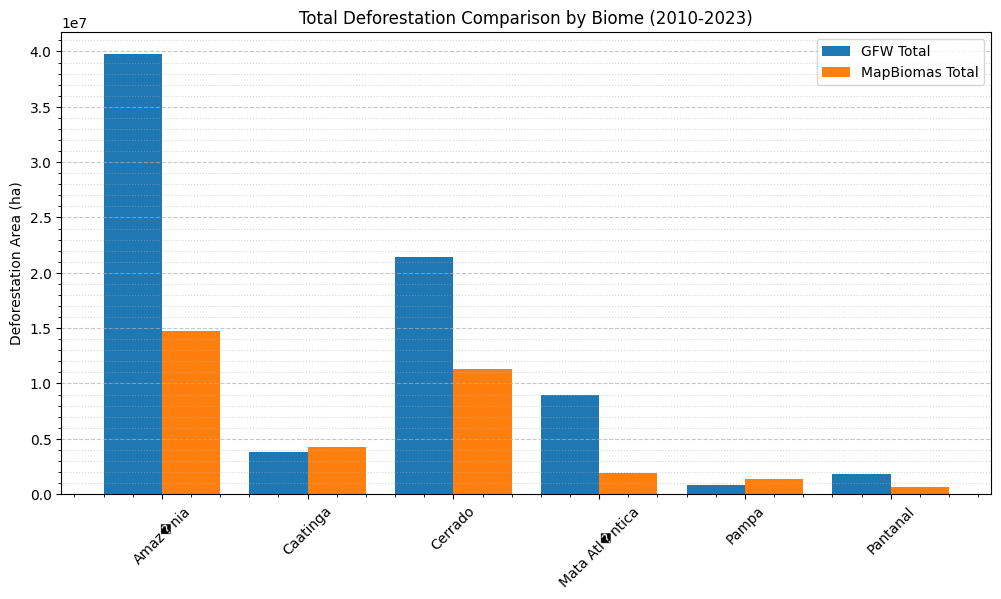

In [18]:
# Bar chart comparing total deforestation for GFW and MapBiomas datasets
plt.figure(figsize=(12, 6))  # Set figure size
x = range(len(gfw_total_summary))  # X-axis positions

# Plot bars for GFW and MapBiomas total deforestation
plt.bar(x, gfw_total_summary, width=0.4, label='GFW Total', align='center')
plt.bar([p + 0.4 for p in x], mapbiomas_total_summary, width=0.4, label='MapBiomas Total', align='center')

# Customize x-axis
plt.xticks([p + 0.2 for p in x], gfw_total_summary.index, rotation=45)  # Rotate biome labels for clarity

# Add labels and title
plt.ylabel("Deforestation Area (ha)")  # Y-axis label
plt.title("Total Deforestation Comparison by Biome (2010-2023)")  # Chart title
plt.legend()  # Add legend

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Major grid lines
plt.minorticks_on()
plt.grid(axis='y', which='minor', linestyle=':', alpha=0.5)  # Minor grid lines

# Display the chart
plt.show()

##### Cropland-Driven Deforestation Comparison

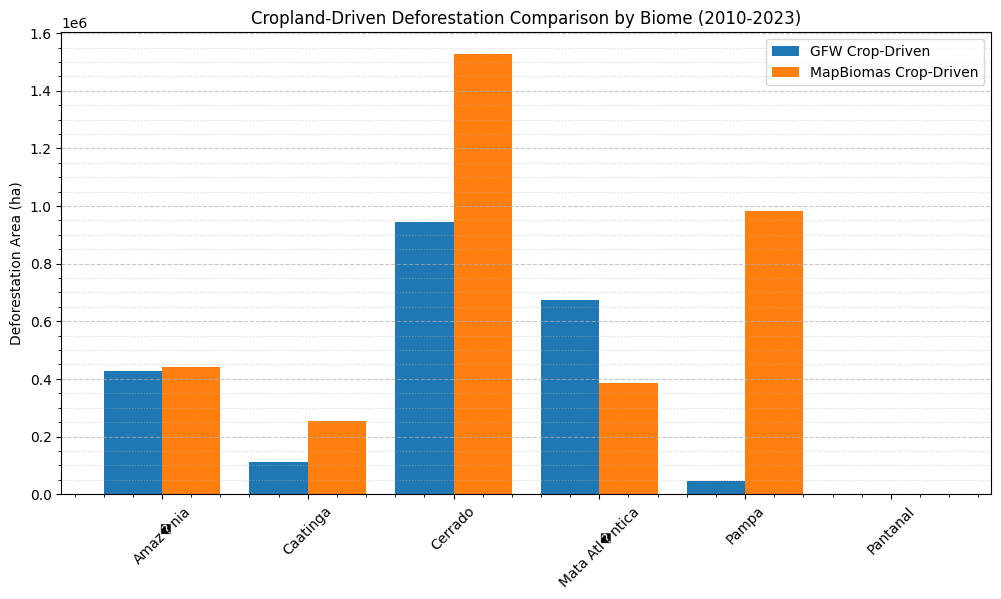

In [19]:
# Bar chart comparing cropland-driven deforestation for GFW and MapBiomas datasets
plt.figure(figsize=(12, 6))  # Set figure size
x = range(len(gfw_crop_summary))  # X-axis positions

# Plot bars for GFW and MapBiomas cropland-driven deforestation
plt.bar(x, gfw_crop_summary, width=0.4, label='GFW Crop-Driven', align='center')
plt.bar([p + 0.4 for p in x], mapbiomas_crop_summary, width=0.4, label='MapBiomas Crop-Driven', align='center')

# Customize x-axis
plt.xticks([p + 0.2 for p in x], gfw_crop_summary.index, rotation=45)  # Rotate biome labels for clarity

# Add labels and title
plt.ylabel("Deforestation Area (ha)")  # Y-axis label
plt.title("Cropland-Driven Deforestation Comparison by Biome (2010-2023)")  # Chart title
plt.legend()  # Add legend

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Major grid lines
plt.minorticks_on()
plt.grid(axis='y', which='minor', linestyle=':', alpha=0.5)  # Minor grid lines

# Display the chart
plt.show()

##### Percentage Cropland-Driven Deforestation

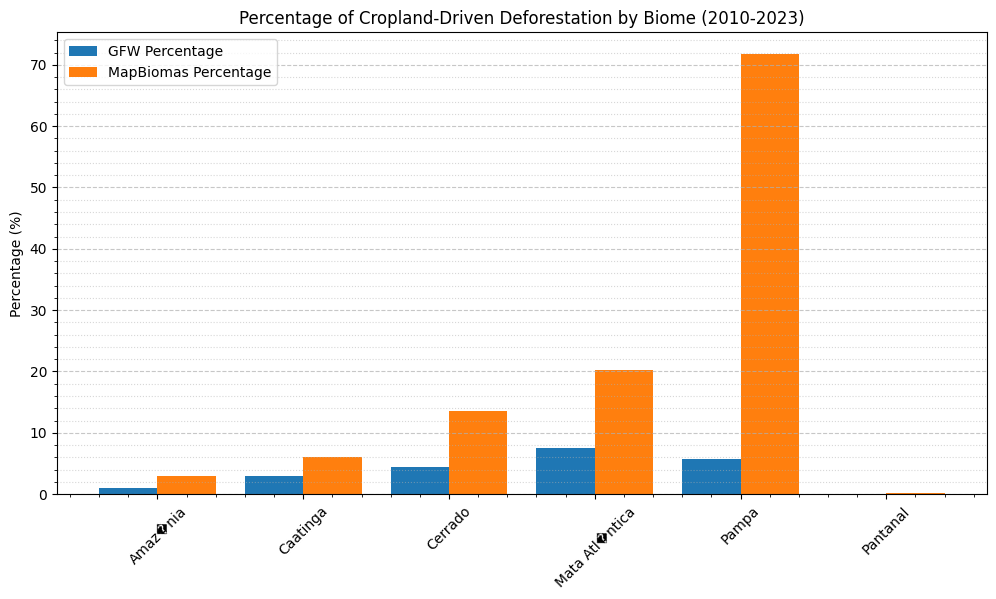

In [20]:
# Bar chart comparing the percentage of cropland-driven deforestation
plt.figure(figsize=(12, 6))  # Set figure size
x = range(len(gfw_percentage))  # X-axis positions

# Plot bars for GFW and MapBiomas percentage comparisons
plt.bar(x, gfw_percentage, width=0.4, label='GFW Percentage', align='center')
plt.bar([p + 0.4 for p in x], mapbiomas_percentage, width=0.4, label='MapBiomas Percentage', align='center')

# Customize x-axis
plt.xticks([p + 0.2 for p in x], gfw_percentage.index, rotation=45)  # Rotate biome labels for clarity

# Add labels and title
plt.ylabel("Percentage (%)")  # Y-axis label
plt.title("Percentage of Cropland-Driven Deforestation by Biome (2010-2023)")  # Chart title
plt.legend()  # Add legend

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Major grid lines
plt.minorticks_on()
plt.grid(axis='y', which='minor', linestyle=':', alpha=0.5)  # Minor grid lines

# Display the chart
plt.show()